#SIM Pattern Generator

###The Python version

From the [SI of the paper](http://www.pnas.org/content/suppl/2012/03/15/1119262109.DCSupplemental/pnas.201119262SI.pdf):



In [115]:
%pylab inline
#nice plotting
#import seaborn as sns
#for minimizing the difference between the desired frequency and the calculated one
from scipy.optimize import minimize
#Need to be able to do polynomial fitting
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
#PIL allows us to write binary images, though we need a cludge, see 'Writing Binary Files.ipynb'
from PIL import Image

Populating the interactive namespace from numpy and matplotlib


In [105]:
def pattern_gen(vecA, period, onfrac = 0.5, phase_idx = 0., phase_offset = 0., nphases =5, sizex =2048, sizey =1536):
    '''
    Generates a binary SLM pattern for SIM
    
    This function follows [Fiolka et al.][1] definition
    
    Parameters
    ----------
    x : array_like
        the $\vec{a}$ from [1]. Defines the pattern orientation
    period : float
        Defines the period of the pattern
    onfrac : float
        The fraction of on pixels in the pattern
    phase_idx : int
        The phase of the pattern (see `nphases` for more info)
    phase_offset : float
        The offset in phase, mostly used for aligning patterns of different colors
    nphases : int
        the number of phases
    sizex : int
        size of the pattern
    sizey : int
        size of the pattern

    Returns
    -------
    pattern : ndarray
        A binary array representing a single bitplane to send to the SLM
    '''
    
    if not 0 < onfrac < 1:
        raise ValueError('onfrac must have a value between 0 and 1. onfrac = {}'.format(onfrac))
    
    vecN = np.array([[0,1],[-1,0]]).dot(vecA)
    vecB = vecN/norm(vecN)*period
    area = vecB.dot(vecN)
    onpix = area*onfrac
    phase_step = vecB/nphases
    
    val = (phase_step*phase_idx+phase_offset/(2*pi)*vecB)
    
    xx, yy = meshgrid(arange(sizex),arange(sizey))
    my_grid = dstack((xx,yy))
        
    return mod((my_grid-val).dot(vecN),area) < onpix

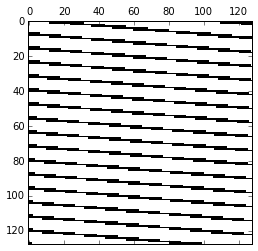

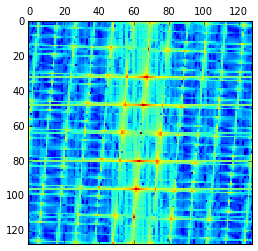

In [3]:
pat =  pattern_gen(array([12, 1]), 8, 0.2, 0, 0., 5, 128, 128)
pat_fft = ifftshift(fftn(fftshift(pat)))
matshow(pat,cmap='Greys')
grid('off')
matshow(log(abs(pat_fft)+0.1))
grid('off')

In [4]:
def angles(phi, num_angles, amp):
    thetas = arange(0., num_angles)*pi/1./num_angles + phi
    return np.round(amp*array([cos(thetas), sin(thetas)])).T

In [5]:
@vectorize
def angle_diff(phi, num_angles, amp):
    my_angles = angles(phi,num_angles,amp)
    return mean(abs(pi/num_angles - abs(diff(arctan2(my_angles[:,0],my_angles[:,1])))))

In [6]:
def best_angles(num_angles, amp):
    x = linspace(0,2*pi,100*amp)
    my_diffs = angle_diff(x,3,12)
    best_offset = x[argmin(my_diffs)]
    return angles(best_offset, num_angles, amp)

In [7]:
def ideal_period(wavelength, NA = 0.85):
    '''
    All units are in mm
    '''
    pixel_size = 8.2/1000 #pixel size in mm for QXGA display (4DD)
    fl = 250 #focal length of lens in mm
    fl2 = 300 #focal length of the second lens
    ftube = 200 #focal length of the tube lens, for Nikon this is 200 mm
    wl = wavelength/10**6 #wavelength of light
    mag = 1/100
    sigma = sqrt(2) * 12/pixel_size/4 #std dev of gaussian beam in units of pixels at the SLM
    pupil_diameter = 2*NA*mag*fl2    #Size of pupil image at first fourier plane
    hole_radius = 2*wl*fl/(2* pi * sigma *sqrt(2) * pixel_size) #this is the limit of hole size
    hole_radius = 0.1/2# this is more reasonable (50 um)
    period = wl * fl * (1/(pupil_diameter/2 - hole_radius))/ pixel_size #in mm
    
    return period

In [10]:
def pattern_period(vecA, period, onfrac = 0.5, phaseInd = 0., phaseOffset = 0., nphases = 5, sizex =2048, sizey =1536):
    '''
    Find the precise pattern period
    
    Using 2nd order polynomial fit along either axis
    '''
    
    #this is a standin for nextpow2, I don't know if there's a more efficient one, but its not going to
    #be a bottle neck
    n = 1<<(min(sizex,sizey)-1).bit_length()
    
    my_pat = pattern_gen(vecA, period, onfrac, phaseInd, phaseOffset, nphases, n, n)
    
    my_pat_fft = abs(ifftshift(fftn(fftshift(my_pat))))

    #I don't know why the first argument is negative?
    my_angle = arctan2(-vecA[0],vecA[1])
    
    peak = np.round(n/(period/array([sin(my_angle), cos(my_angle)])))
    
    #pull the 3x3 region around the peak
    region_size = 3
    start = -(region_size-1)/2
    end = region_size+start

    my_pat_fft_subx = my_pat_fft[n/2+peak[0]+start:n/2+peak[0]+end,n/2+peak[1]]
    my_pat_fft_suby = my_pat_fft[n/2+peak[0],n/2+peak[1]+start:n/2+peak[1]+end]

    x = arange(start,end)
    
    xfit = polyfit(x, my_pat_fft_subx,2)
    yfit = polyfit(x, my_pat_fft_suby,2)

    x0 = -xfit[1]/(2*xfit[0])
    y0 = -yfit[1]/(2*yfit[0])

    #precisepeak = peak+poly2dmax(insert(clf.coef_,(3),0))
    precisepeak = peak+[x0,y0]
    #print(precisepeak)
    
    preciseangle = arctan2(precisepeak[0],precisepeak[1])
    
    #precise_period = n/norm(precisepeak)
    precise_period = n/precisepeak[0]*sin(preciseangle)
    
    #print('{:.20f}'.format(precise_period))
    
    return precise_period

In [25]:
def objf(period):
    data = array([pattern_period(angle, period,phaseInd = n,sizex = 1024) for n in range(1)])
    return mean(abs(data-ideal_period(568))/ideal_period(568))

In [19]:
from scipy.optimize import minimize_scalar

In [72]:
res.keys()

dict_keys(['nfev', 'x', 'njev', 'success', 'hess_inv', 'fun', 'jac', 'message', 'status'])

In [71]:
#testing different solvers, note that Nelder-Mead and Powell methods are the
#only ones that seem to work for this function.
def objf_l1(period, iperiod, size = 1024):
    angle = array([1,12])
    data = array([pattern_period(angle, period,phaseInd = n,sizex = size) for n in range(1)])
    return mean(abs(data-iperiod))

def objf_l2(*args):
    return objf_l1(*args)**2

%timeit minimize(objf_l1, 8.4,method='Nelder-Mead',args=(ideal_period(568, 0.7),512))
%timeit minimize(objf_l1, 8.4,method='Powell',args=(ideal_period(568, 0.7),512))

%timeit minimize(objf_l2, 8.4,method='Nelder-Mead',args=(ideal_period(568, 0.7),512))
%timeit minimize(objf_l2, 8.4,method='Powell',args=(ideal_period(568, 0.7),512))

res_l1_nm = minimize(objf_l1, 8.4,method='Nelder-Mead',args=(ideal_period(568, 0.7),512))
res_l1_p = minimize(objf_l1, 8.4,method='Powell',args=(ideal_period(568, 0.7),512))

res_l2_nm = minimize(objf_l2, 8.4,method='Nelder-Mead',args=(ideal_period(568, 0.7),512))
res_l2_p = minimize(objf_l2, 8.4,method='Powell',args=(ideal_period(568, 0.7),512))

1 loops, best of 3: 2.34 s per loop
1 loops, best of 3: 3.91 s per loop
1 loops, best of 3: 2.18 s per loop
1 loops, best of 3: 5.28 s per loop
L1-norm: Nelder-Mead = [ 8.43614502]	Powell = 8.436047020234469
L2-norm: Nelder-Mead = [ 8.43614502]	Powell = 8.436255263697804


In [79]:
print('x values')
print('L1-norm: Nelder-Mead = {}\tPowell = {}'.format(res_l1_nm['x'][0],res_l1_p['x']))
print('L2-norm: Nelder-Mead = {}\tPowell = {}'.format(res_l2_nm['x'][0],res_l2_p['x']))
print('Func Calls')
print('L1-norm: Nelder-Mead = {}\tPowell = {}'.format(res_l1_nm['nfev'],res_l1_p['nfev']))
print('L2-norm: Nelder-Mead = {}\tPowell = {}'.format(res_l2_nm['nfev'],res_l2_p['nfev']))
print('Differences')
print('L1-norm: Nelder-Mead - Powell = {}'.format(res_l1_nm['fun']-res_l1_p['fun']))
print('L1-norm: Nelder-Mead - Powell = {}'.format(res_l1_nm['fun']**2-res_l1_p['fun']**2))
print('L2-norm: Nelder-Mead - Powell = {}'.format(res_l2_nm['fun']-res_l2_p['fun']))

x values
L1-norm: Nelder-Mead = 8.436145019531251	Powell = 8.436047020234469
L2-norm: Nelder-Mead = 8.436145019531251	Powell = 8.436255263697804
Func Calls
L1-norm: Nelder-Mead = 33	Powell = 55
L2-norm: Nelder-Mead = 28	Powell = 73
Differences
L1-norm: Nelder-Mead - Powell = -0.0003552140126465986
L1-norm: Nelder-Mead - Powell = -1.4063966543938126e-07
L2-norm: Nelder-Mead - Powell = -3.68334662853476e-07


It looks like the simplex (`'Nelder-Mead'`) algorithm is the best for this problem. Barring more complex convex methods.

In [82]:
iperiod = ideal_period(568,0.7)

def objf(period, iperiod, size = 1024):
    return objf_l1(period, iperiod, size)/iperiod*100

x = linspace(iperiod-0.05,iperiod+0.05,101)
y512 = array([objf(period, iperiod,512) for period in x])
y1024 = array([objf(period, iperiod,1024) for period in x])

In [85]:
res_512 = minimize(objf, iperiod ,method='Nelder-Mead',args=(ideal_period(568, 0.7),512))
res_1024 = minimize(objf, iperiod ,method='Nelder-Mead',args=(ideal_period(568, 0.7),1024))

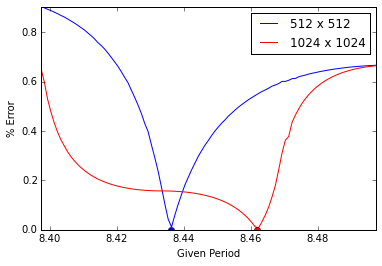

In [92]:
plot(x,y512,'b',label='512 x 512')
plot(res_512['x'],res_512['fun'],'bo')#,label='512 Optimized point')
plot(x,y1024,'r',label='1024 x 1024')
plot(res_1024['x'],res_1024['fun'],'ro')#,label='1024 Optimized point')
axis('tight')
xlabel('Given Period')
ylabel('% Error')
legend(loc='best')
#savefig("PeriodOpt 1D Parabola.pdf")

In [129]:
def opt_period(iperiod,angle,**kwargs):
    def objf_l1(period):
        data = array([pattern_period(angle, period, **kwargs) for n in range(1)])
        return mean(abs(data-iperiod))
    
    return minimize(objf_l1, iperiod ,method='Nelder-Mead')['x']

In [128]:
%timeit opt_period(ideal_period(568, 0.85),array([1,12]))

Optimization terminated successfully.
         Current function value: 0.000080
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000080
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000080
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000080
         Iterations: 15
         Function evaluations: 30
1 loops, best of 3: 38 s per loop


In [112]:
my_per = opt_period(ideal_period(568, 0.7),array([1,12]))

Optimization terminated successfully.
         Current function value: 0.000060
         Iterations: 15
         Function evaluations: 30


In [125]:
pat = pattern_gen([1,12], my_per)

#this is cludgy but seems necessary.
pat_img = Image.fromarray((pat*255).astype('uint8'),mode='L')

#write the image
pat_img.convert('1').save('TestPat.bmp')

In [126]:
my_per

array([ 8.45024004])

In [127]:
iperiod

8.447352766210592